In [8]:
import json
from generate_dataset import Sample
from matplotlib import pyplot as plt

# Load dataset
with open("dataset.json", "r") as f:
    dataset = [Sample.model_validate(sample) for sample in json.load(f)]

MODEL_NAMES = ["gpt4o", "gpt4o_vis", "gpt4o_vis_and_text", "gpt4_mini", "gpt4_mini_vis", "gpt4_mini_vis_and_text", "Llama8B", "Llama3B"]
PREDICTION_FILES = ["predictions_"+name+".json" for name in MODEL_NAMES]
dataset_predictions = []
for file in PREDICTION_FILES:
    with open(file, "r") as f:
        dataset_predictions.append(json.load(f))

### Cleaning predicitons

In [9]:
for dataset_pred in dataset_predictions:
    for key in dataset_pred: 
        dataset_pred[key] = dataset_pred[key].replace(",","")
        if dataset_pred[key] not in ["shift", "static", "rotate", "flip"]: 
            dataset_pred[key] = "rotate"

### Accuracies

In [10]:
from sklearn.metrics import f1_score
for i, predictions in enumerate(dataset_predictions): 
    data = [(predictions[sample.uuid], sample.transformation.type.value)for sample in dataset]
    preds, labels = zip(*data)
    correct = 0
    for j in range(len(preds)):
        if preds[j] == labels[j]:
            correct+=1
    print(MODEL_NAMES[i])
    print("Accuracy:", round(correct / len(preds),2))
    print("F1:", round(f1_score(labels, preds, average = "macro"),2))
    print()


gpt4o
Accuracy: 0.49
F1: 0.44

gpt4o_vis
Accuracy: 0.37
F1: 0.33

gpt4o_vis_and_text
Accuracy: 0.55
F1: 0.5

gpt4_mini
Accuracy: 0.39
F1: 0.35

gpt4_mini_vis
Accuracy: 0.26
F1: 0.12

gpt4_mini_vis_and_text
Accuracy: 0.3
F1: 0.21

Llama8B
Accuracy: 0.25
F1: 0.17

Llama3B
Accuracy: 0.2
F1: 0.11



### Calculate the F1-scores

In [11]:
from sklearn.metrics import classification_report, f1_score
for i, predictions in enumerate(dataset_predictions): 
    data = [(predictions[sample.uuid], sample.transformation.type.value)for sample in dataset]
    preds, labels = zip(*data)
    print(MODEL_NAMES[i])
    print(classification_report(labels, preds, target_names=["shift", "static", "rotate", "flip"], zero_division=0))

gpt4o
              precision    recall  f1-score   support

       shift       0.00      0.00      0.00        87
      static       1.00      0.21      0.35        66
      rotate       0.34      0.96      0.51        71
        flip       0.82      1.00      0.90        56

    accuracy                           0.49       280
   macro avg       0.54      0.54      0.44       280
weighted avg       0.49      0.49      0.39       280

gpt4o_vis
              precision    recall  f1-score   support

       shift       1.00      0.01      0.02        87
      static       0.32      0.77      0.45        66
      rotate       0.41      0.44      0.42        71
        flip       0.48      0.38      0.42        56

    accuracy                           0.37       280
   macro avg       0.55      0.40      0.33       280
weighted avg       0.59      0.37      0.30       280

gpt4o_vis_and_text
              precision    recall  f1-score   support

       shift       0.00      0.00      0

### Measuring the effect of grid-size

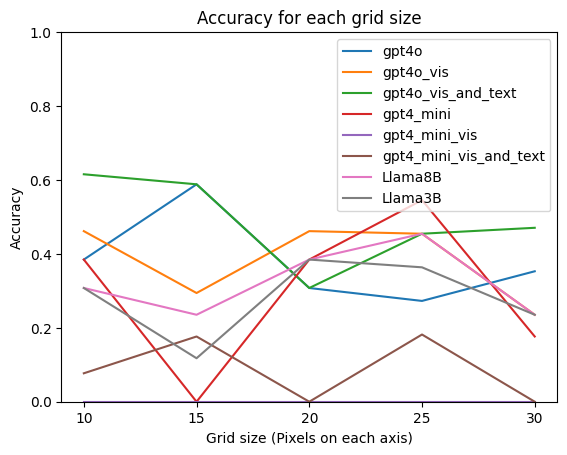

In [12]:
DISREGARD_SHIFTS = True
grid_sizes = list(range(10, 31, 5)) # Plot accuracy for each grid size

for i, predictions in enumerate (dataset_predictions): 
    accuracies = []
    for grid_size in grid_sizes:
        grid_size_samples = [sample for sample in dataset if sample.configuration.grid_size == grid_size and sample.configuration.shape_size == 5 and sample.configuration.number_of_shapes == 1]
        if DISREGARD_SHIFTS: 
            grid_size_samples = [sample for sample in grid_size_samples if sample.transformation.type.value != "shift"]
        grid_size_samples_predictions = [predictions[sample.uuid] for sample in grid_size_samples]
        accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(grid_size_samples_predictions, grid_size_samples)]) / len(grid_size_samples)
        accuracies.append(accuracy)

    plt.plot(grid_sizes, accuracies, label=MODEL_NAMES[i])

# Make a title, x label, and y label, x ticks
plt.title("Accuracy for each grid size")
plt.xlabel("Grid size (Pixels on each axis)")
plt.ylabel("Accuracy")
plt.ylim(bottom=0, top=1)
plt.xticks(grid_sizes)
plt.legend()
plt.show()

### Measuring the effect of the shape-size

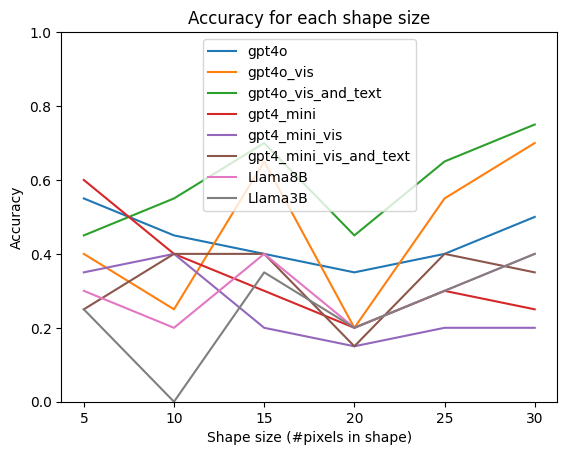

In [13]:
# Plot accuracy for each shape size
shape_sizes = list(range(5, 31, 5))

for i, predictions in enumerate (dataset_predictions): 
    accuracies = []
    for shape_size in shape_sizes:
        shape_size_samples = [sample for sample in dataset if sample.configuration.shape_size == shape_size and sample.configuration.grid_size == 20 and sample.configuration.number_of_shapes == 1]
        shape_size_samples_predictions = [predictions[sample.uuid] for sample in shape_size_samples]
        accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(shape_size_samples_predictions, shape_size_samples)]) / len(shape_size_samples)
        accuracies.append(accuracy)
    
    plt.plot(shape_sizes, accuracies, label=MODEL_NAMES[i])

plt.title("Accuracy for each shape size")
plt.xlabel("Shape size (#pixels in shape)")
plt.ylabel("Accuracy")
plt.ylim(bottom=0, top=1)
plt.xticks(shape_sizes)
plt.legend()
plt.show()

### Measuring the effect of the number of shapes affected

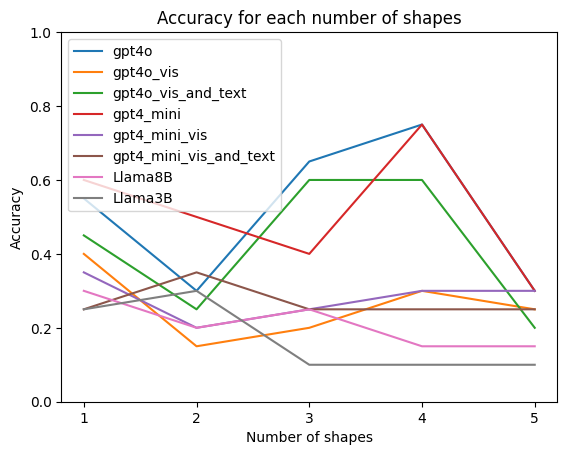

In [14]:
x_axis = list(range(1, 6))

for i, predictions in enumerate (dataset_predictions): 
    accuracies = []
    for number_of_shapes in x_axis:
        number_of_shapes_samples = [sample for sample in dataset if sample.configuration.number_of_shapes == number_of_shapes and sample.configuration.shape_size == 5 and sample.configuration.grid_size == 20]
        number_of_shapes_samples_predictions = [predictions[sample.uuid] for sample in number_of_shapes_samples]
        accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(number_of_shapes_samples_predictions, number_of_shapes_samples)]) / len(number_of_shapes_samples)
        accuracies.append(accuracy)
    plt.plot(x_axis, accuracies, label=MODEL_NAMES[i])

plt.title("Accuracy for each number of shapes")
plt.xlabel("Number of shapes")
plt.ylabel("Accuracy")
plt.ylim(bottom=0, top=1)
plt.xticks(x_axis)
plt.legend()
plt.show()
